In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col, from_json, substring, when, length, split, lit
from pyspark.sql.types import StructType, StructField, StringType
from pyspark import StorageLevel

In [2]:
# Nomes de aquivos e pastas
parquet_dir_name = 'output/embeddings_nome_1m'
investigaCEP='7291'
parquet_nodes = 'dataset/grapho/nodes_1m'

In [3]:
spark = SparkSession.builder \
        .config("spark.driver.memory", "128g") \
        .appName("gera_embedding_nome") \
        .getOrCreate()

23/12/09 10:47:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Carrega pj
pj = spark.read.parquet(parquet_nodes)

In [5]:
pj.printSchema()

root
 |-- id: string (nullable = true)
 |-- te_dados_em: struct (nullable = true)
 |    |-- porteEmpresa: string (nullable = true)
 |    |-- capitalSocial: string (nullable = true)
 |    |-- cpfResponsavel: string (nullable = true)
 |    |-- nomeEmpresarial: string (nullable = true)
 |    |-- naturezaJuridica: string (nullable = true)
 |    |-- qualificacaoResponsavel: string (nullable = true)
 |-- id_estabelecimento: string (nullable = true)
 |-- te_dados_es: struct (nullable = true)
 |    |-- uf: string (nullable = true)
 |    |-- cep: string (nullable = true)
 |    |-- ddd1: string (nullable = true)
 |    |-- ddd2: string (nullable = true)
 |    |-- pais: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- bairro: string (nullable = true)
 |    |-- numero: string (nullable = true)
 |    |-- municipio: string (nullable = true)
 |    |-- telefone1: string (nullable = true)
 |    |-- telefone2: string (nullable = true)
 |    |-- cnaeFiscal: string (nullable = t

In [6]:
# Carrega embeddings
nomes_pj = spark.read.parquet(parquet_dir_name)

In [7]:
nomes_pj.printSchema()

root
 |-- id: string (nullable = true)
 |-- nomeFantasia: string (nullable = true)
 |-- embeddings: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [8]:
cnpjs_filtrados = pj \
    .filter(col("te_dados_es.cep").startswith(investigaCEP)) \
    .select(col("id"))

# Filtrando 'nomes_pj' com base nos CNPJs filtrados
nomes_filtrados = nomes_pj.join(cnpjs_filtrados, nomes_pj["id"] == pj["id"], "inner") \
                          .select(nomes_pj["id"], nomes_pj["nomeFantasia"],  nomes_pj["embeddings"])
nomes_filtrados.persist(StorageLevel.MEMORY_AND_DISK)
nomes_filtrados.show()

+--------+--------------------+--------------------+
|      id|        nomeFantasia|          embeddings|
+--------+--------------------+--------------------+
|03914415|CANAA REPRESENTAC...|[-0.104114175, -0...|
|03911104|   GRAFICA MILLENIUM|[-0.03736859, 0.2...|
|03916526|CORINGAO DA CONST...|[0.027917892, 0.2...|
|03893388|LOVE CAR ESTACION...|[0.26645648, 0.17...|
|03894648|   ESCOLA CRISTO REI|[0.07743183, 0.10...|
|03894674|CRECHE E ESCOLA S...|[0.09698044, 0.23...|
|03893548|  MERCEARIA MONTEIRO|[0.21297781, -0.0...|
|03894626|        LAPIS MAGICO|[-0.13586347, 0.1...|
|03896965|            BRASIBOX|[-0.07320238, 0.0...|
|03891623|   MAGAZINNE CENTRAL|[0.13838959, -0.0...|
|03984082|RENASCER MATERIAI...|[-0.10572131, 0.2...|
|03979946|VITAL MATERIAIS P...|[-0.05022287, 0.1...|
|03986748|      ANJOS NOTURNOS|[-0.12343089, 0.1...|
|03976865|    FARMACIA DO POVO|[0.1455577, 0.059...|
|03258039|        BARAO MOVEIS|[-0.03246181, 0.1...|
|03251259|PERFUMARIA NOSSA ...|[0.1379763, 0.1

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Converter os embeddings para um formato compatível com o cosine_similarity
embeddings = np.array(nomes_filtrados.select("embeddings").collect())
embeddings =  np.vstack(embeddings)
# print(embeddings)
# Calcular a matriz de similaridade usando cosine_similarity
matriz_similaridade = cosine_similarity(embeddings, embeddings)

# Imprimir a matriz de similaridade
print(matriz_similaridade)

[[1.         0.26949791 0.57017729 ... 0.65224173 0.33840268 0.42252484]
 [0.26949791 1.         0.41274305 ... 0.38646856 0.33983886 0.45276208]
 [0.57017729 0.41274305 1.         ... 0.72337324 0.45927652 0.56822478]
 ...
 [0.65224173 0.38646856 0.72337324 ... 1.         0.46511533 0.48302686]
 [0.33840268 0.33983886 0.45927652 ... 0.46511533 1.         0.54523073]
 [0.42252484 0.45276208 0.56822478 ... 0.48302686 0.54523073 1.        ]]


In [10]:
inter_x = 0
inter_y = 30
nova_matriz_similaridade = matriz_similaridade[inter_x:inter_y, inter_x:inter_y]

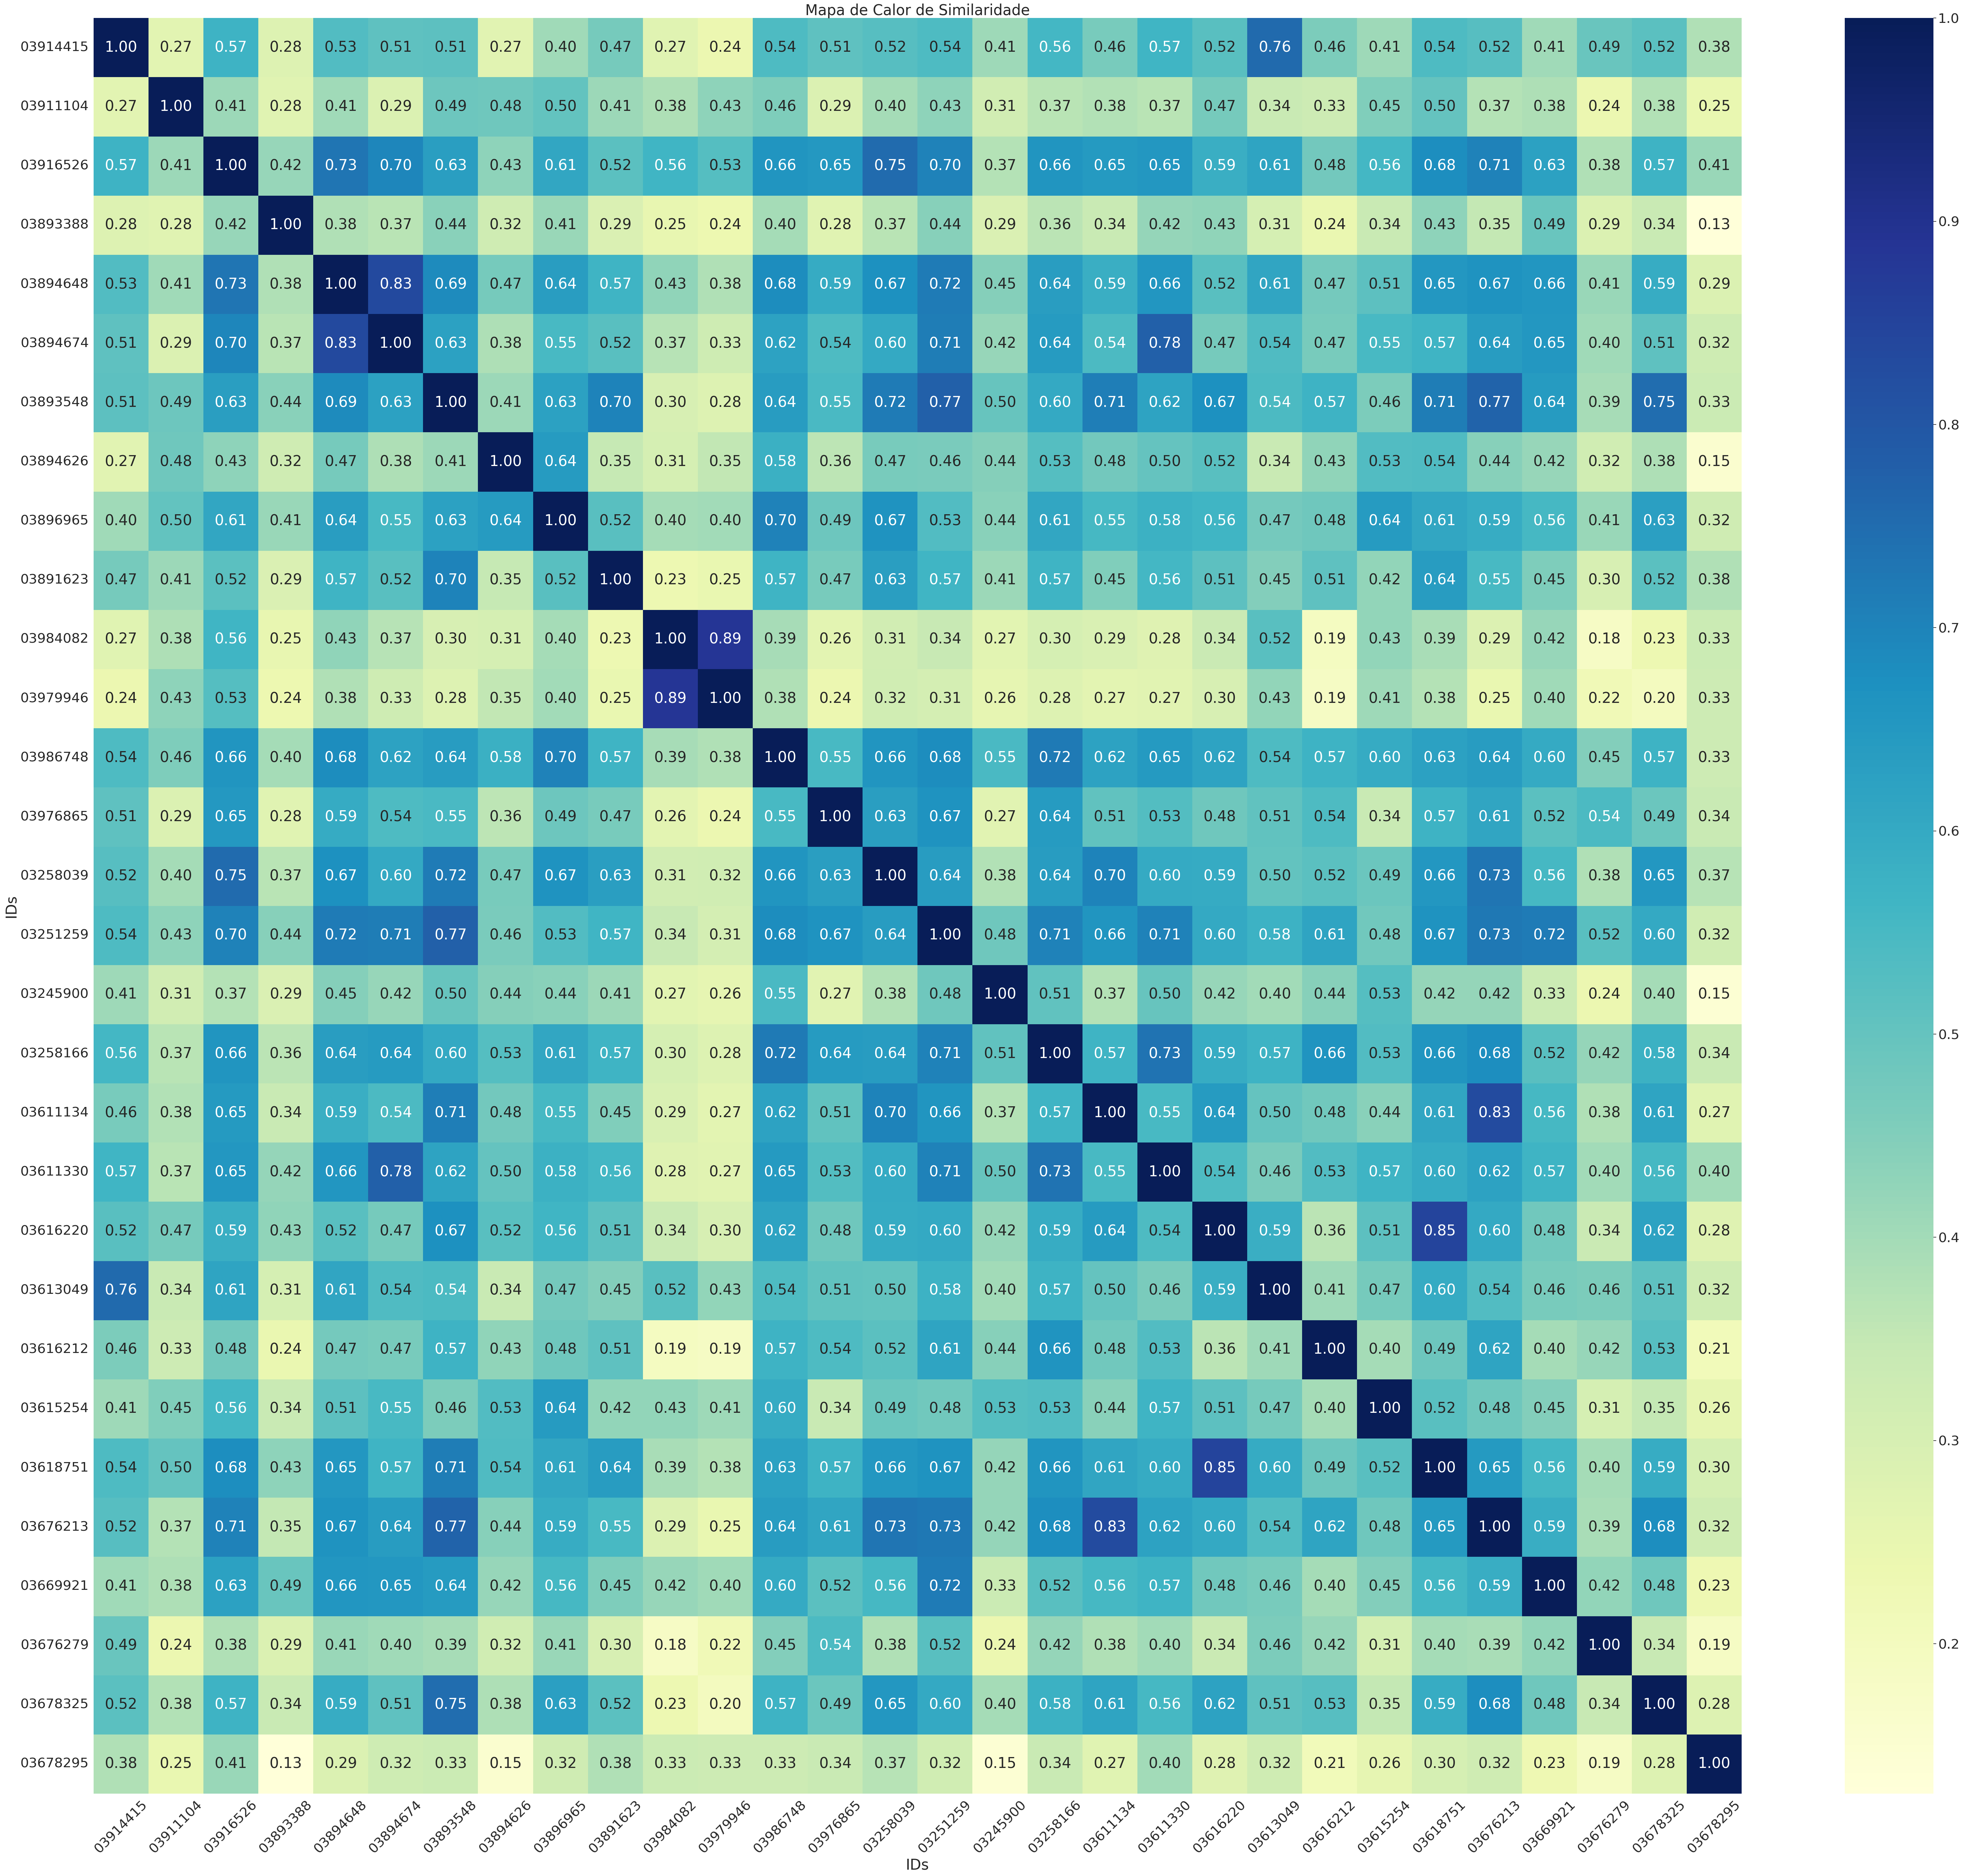

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtendo os IDs dos nomes filtrados
ids = nomes_filtrados.select("id").rdd.flatMap(lambda x: x).collect()[inter_x:inter_y]

# Plotando o mapa de calor da matriz de similaridade
sns.set(style="white")  # Configuração do estilo do plot
plt.figure(figsize=(62, 54))  # Definindo o tamanho da figura

# Criando o mapa de calor
sns.set(font_scale=2.5)
ax = sns.heatmap(nova_matriz_similaridade, annot=True, fmt=".2f", xticklabels=ids, yticklabels=ids, cmap="YlGnBu")

# Configurações adicionais
plt.title('Mapa de Calor de Similaridade')
plt.xlabel('IDs')
plt.ylabel('IDs')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrando o mapa de calor
plt.show()

In [12]:
import numpy as np
n = 27
# Criar uma máscara para a diagonal e abaixo dela
mask = np.triu(np.ones(matriz_similaridade.shape), k=1).astype(bool)

# Aplicar a máscara para ignorar a diagonal e valores abaixo dela
valores_acima_diagonal = matriz_similaridade[mask]

# Encontrar os índices dos n maiores valores acima da diagonal
indices_maior_valor = np.argsort(valores_acima_diagonal)[-n:][::-1]

# Obter os valores e suas coordenadas na matriz de similaridade
valores_maior_valor = valores_acima_diagonal[indices_maior_valor]
coordenadas = np.argwhere(mask)

# Imprimir os n maiores valores e suas coordenadas acima da diagonal
for i in range(n):
    idx = coordenadas[indices_maior_valor[i]]
    print(f"Valor: {valores_maior_valor[i]}, Coordenada: {idx[0]}, {idx[1]}")

Valor: 1.0000000000000009, Coordenada: 28, 135
Valor: 1.0000000000000004, Coordenada: 160, 166
Valor: 1.0000000000000004, Coordenada: 66, 266
Valor: 1.0000000000000004, Coordenada: 133, 137
Valor: 1.0000000000000004, Coordenada: 168, 177
Valor: 0.9690009100064597, Coordenada: 189, 209
Valor: 0.9685788562236568, Coordenada: 217, 248
Valor: 0.9563880858424363, Coordenada: 17, 134
Valor: 0.9445912338383725, Coordenada: 39, 226
Valor: 0.9426009204448242, Coordenada: 223, 237
Valor: 0.9353482499421719, Coordenada: 43, 230
Valor: 0.9268796610938796, Coordenada: 11, 30
Valor: 0.9266001888067685, Coordenada: 115, 133
Valor: 0.9266001888067685, Coordenada: 115, 137
Valor: 0.925082399716076, Coordenada: 137, 257
Valor: 0.925082399716076, Coordenada: 133, 257
Valor: 0.9248165200062233, Coordenada: 60, 172
Valor: 0.9217692876487046, Coordenada: 115, 257
Valor: 0.9214245042674518, Coordenada: 121, 243
Valor: 0.9165248301241429, Coordenada: 100, 211
Valor: 0.9150920573712007, Coordenada: 70, 285
Val

In [13]:
# Imprimir os n maiores valores, suas coordenadas e os campos 'id' e 'nomeFantasia' correspondentes no DataFrame 'nomes_filtrados'
for i in range(n):
    idx = coordenadas[indices_maior_valor[i]]
    idx_x, idx_y = idx[0], idx[1]
    
    # Acessar os campos 'id' e 'nomeFantasia' com base nos índices na matriz de similaridade
    id_x = nomes_filtrados.select("id").collect()[idx_x]['id']
    nome_x = nomes_filtrados.select("nomeFantasia").collect()[idx_x]['nomeFantasia']
    id_y = nomes_filtrados.select("id").collect()[idx_y]['id']
    nome_y = nomes_filtrados.select("nomeFantasia").collect()[idx_y]['nomeFantasia']
    
    print(f"Valor: {valores_maior_valor[i]}, Coordenada: {idx_x}, {idx_y}")
    print(f"Par de nomes: ({id_x}, {nome_x}) e ({id_y}, {nome_y})")

Valor: 1.0000000000000009, Coordenada: 28, 135
Par de nomes: (03678325, KAROL CALCADOS) e (03486143, KAROL CALCADOS)
Valor: 1.0000000000000004, Coordenada: 160, 166
Par de nomes: (03454504, PREMOFORT) e (03454523, PREMOFORT)
Valor: 1.0000000000000004, Coordenada: 66, 266
Par de nomes: (04145495, SUPERMERCADO CANDANGO) e (03945519, SUPERMERCADO CANDANGO)
Valor: 1.0000000000000004, Coordenada: 133, 137
Par de nomes: (03485881, VILSON COMERCIO E REPRESENTACOES) e (03485886, VILSON COMERCIO E REPRESENTACOES)
Valor: 1.0000000000000004, Coordenada: 168, 177
Par de nomes: (03633147, SUPERMERCADO VALDOR) e (04219484, SUPERMERCADO VALDOR)
Valor: 0.9690009100064597, Coordenada: 189, 209
Par de nomes: (03661812, COLOMBO PRODUTOS METALURGICOS) e (03393650, FERRACO PRODUTOS METALURGICOS)
Valor: 0.9685788562236568, Coordenada: 217, 248
Par de nomes: (03434350, GRANN - LAR MOVEIS E ELETROS) e (03819121, GRAN LAR MOVEIS E ELETROS)
Valor: 0.9563880858424363, Coordenada: 17, 134
Par de nomes: (03258166,

In [14]:
spark.stop()